In [1]:
import pickle
import os
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
#     np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_STANDARD = LiH_data['experiment_data'].copy()
del LiH_data

In [5]:
STANDARD_data = experimental_data_STANDARD[101852100]['standard'].copy()
del experimental_data_STANDARD

In [6]:
len(STANDARD_data)

10

In [7]:
STANDARD_Hist_data_sim={} 
for exp_instance in STANDARD_data: #each exp repeated 10 times!
    for exp_dict_key in exp_instance:
        
        exp_dict= exp_instance[exp_dict_key]
        
        P=exp_dict['qubitOp']
        coeff = exp_dict['coeff']
        measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in STANDARD_Hist_data_sim.keys():
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': np.hstack((STANDARD_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': M_list_sim}
            
        del exp_dict

In [8]:
del STANDARD_data

In [9]:
# for key in STANDARD_Hist_data_sim:
#     STANDARD_Hist_data_sim[key]['Measurements']=STANDARD_Hist_data_sim[key]['Measurements'].tolist()
#     STANDARD_Hist_data_sim[key]['P']=(STANDARD_Hist_data_sim[key]['P'][0], STANDARD_Hist_data_sim[key]['P'][1].real)

In [10]:
# import json
# with open("STANDARD_Hist_data_sim", "w") as write_file:
#     json.dump(STANDARD_Hist_data_sim, write_file)


In [11]:
STANDARD_Hist_data_sim[0]['Measurements'].shape

(1616700,)

In [12]:
# ### save output
# np.save('Standard_hist_data', STANDARD_Hist_data_sim)

In [13]:
import matplotlib.pyplot as plt

In [14]:
fci_energy= -7.971184315565538

# Histogram

In [15]:
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[0]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [16]:
I_term = -4.142299396835105
E_list_STANDARD_sim=Get_Hist_data(STANDARD_Hist_data_sim, I_term)

100%|██████████| 1616700/1616700 [31:34<00:00, 853.19it/s]


In [17]:
import json
with open("E_list_STANDARD_sim.json", "w") as write_file:
    json.dump(E_list_STANDARD_sim, write_file)


In [18]:
E_list_STANDARD_sim=np.array(E_list_STANDARD_sim)

In [75]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean)**2 / (2*standard_deviation**2)))

In [20]:
from scipy.optimize import curve_fit

In [77]:
# from matplotlib import pyplot
# %matplotlib inline


# # bins_standard = len(set(E_list_STANDARD_sim))
# bins_standard = 1000

# bin_heights_STANDARD, bin_borders_STANDARD, _=pyplot.hist(E_list_STANDARD_sim,
#                                                           bins_standard, alpha=0.7,
#                                                           label='$E$ standard VQE - sim',
#                                                           color='g',
#                                                           density=False)

# bin_centers_STANDARD = bin_borders_STANDARD[:-1] + np.diff(bin_borders_STANDARD) / 2
# popt, _ = curve_fit(gaussian, bin_centers_STANDARD, bin_heights_STANDARD, p0=[fci_energy, 0., 1.], **{'maxfev':10000})
# mean_STANDARD, amplitude_STANDARD, standard_deviation_STANDARD= popt
# x_interval_for_fit = np.linspace(bin_borders_STANDARD[0], bin_borders_STANDARD[-1], 10000)
# pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='g')


# pyplot.axvline(mean_STANDARD, color='g', linestyle='dashed', linewidth=1, 
#             label='$E_{average}$ standard VQE - sim') # mean of GAUSSIAN FIT

# # pyplot.axvline(E_list_STANDARD_sim.mean(), color='g', linestyle='dashed', linewidth=1, 
# #             label='$E_{average}$ standard VQE - sim') # mean of DATA

# pyplot.errorbar(mean_STANDARD,65_000,
#              xerr=standard_deviation_STANDARD, linestyle="None", color='g',
#              uplims=True, lolims=True, label='$\sigma_{E_{av}}$standard VQE - sim')




# pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=2, 
#             label='$E_{FCI}$', alpha=0.4)

# pyplot.legend(loc='upper right')
# # pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
# pyplot.ylabel('Frequency')
# pyplot.xlabel('Energy')

# pyplot.tight_layout()

# file_name = 'LiH_Histogram_STANDARD_sim_Gaussian.jpeg'
# pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
# pyplot.show()

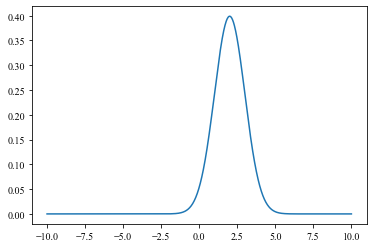

In [57]:
def normal_dist(x, mean, standard_deviation):
    return (1/(np.sqrt(2*np.pi)*standard_deviation)) * np.exp( - ((x - mean)**2 / (2*standard_deviation**2)))

plt.plot(x, normal_dist(x, av, sig))

In [58]:
# from scipy.stats import norm

# x=np.linspace(-10, 10, 1000)
# av=2
# sig=1
# plt.plot(x, norm.pdf(x, av, sig))

In [90]:
len(set(np.around(E_list_STANDARD_sim, 5)))

154905

In [164]:
E_list_STANDARD_sim.shape

(1616700,)

In [166]:
 E_list_STANDARD_sim.shape[0]**(1/3)

117.36622772049694

In [178]:
# https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
from scipy.stats import iqr

bin_width = 2 * iqr(E_list_STANDARD_sim) / E_list_STANDARD_sim.shape[0]**(1/3)
np.ceil((max(E_list_STANDARD_sim)-min(E_list_STANDARD_sim))/bin_width)

819.0

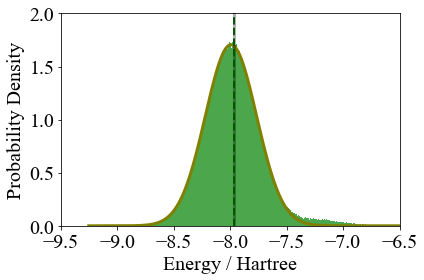

In [181]:
from matplotlib import pyplot
%matplotlib inline


# bins = len(set(E_list_SEQ_ROT_sim))
# bins_standard = len(set(E_list_STANDARD_sim))

# bins_standard = 150_000
bins_standard = 2500

bin_heights_STANDARD, bin_borders_STANDARD, _=pyplot.hist(E_list_STANDARD_sim,
                                                          bins_standard, alpha=0.7,
                                                          label='$E$ standard VQE - sim',
                                                          color='g',
                                                          density=True)
####                                                          ,hatch='-')

###### Gaussian fit
bin_centers_STANDARD = bin_borders_STANDARD[:-1] + np.diff(bin_borders_STANDARD) / 2
popt, _ = curve_fit(gaussian, bin_centers_STANDARD, bin_heights_STANDARD, p0=[fci_energy, 0., 1.])#, **{'maxfev':10000})
mean_STANDARD, amplitude_STANDARD, standard_deviation_STANDARD= popt
x_interval_for_fit = np.linspace(bin_borders_STANDARD[0], bin_borders_STANDARD[-1], 10000)
pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='olive',
           linewidth=3)




### normal fit
# popt_norm, _ = curve_fit(normal_dist, bin_centers_STANDARD, bin_heights_STANDARD, p0=[fci_energy, standard_deviation_STANDARD])#, **{'maxfev':10000})
# mean_norm, standard_deviation_norm= popt_norm
# pyplot.plot(x_interval_for_fit, normal_dist(x_interval_for_fit, *popt_norm), label='Normal fit', color='b',
#            linestyle='--')

# pyplot.plot(x_interval_for_fit, normal_dist(x_interval_for_fit, mean_STANDARD, standard_deviation_STANDARD), 
#             label='Normal fit', color='b', linestyle='--')





#### Average energy from data
pyplot.axvline(E_list_STANDARD_sim.mean(), color='g', linestyle='--', linewidth=2, 
            label='$E_{average}$ standard VQE - sim') # mean of DATA



##############

# chemical accuracy
pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=3, 
            label='$E_{FCI}$', alpha=0.3)

# # chemical accuracy
# pyplot.fill_between([fci_energy-1.6e-3, fci_energy+1.6e-3],
#                  [0, np.ceil(max(bin_heights_STANDARD))] ,
#                  color='k', 
#                  label='chemical accuracy',
#                 alpha=0.5)


pyplot.rcParams["font.family"] = "Times New Roman"
# pyplot.legend(loc='upper right')
# # pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-9.5,-5.5,0.5), fontsize=20)
pyplot.yticks(np.arange(0,2.5,0.5), fontsize=20)

# pyplot.xlim(np.floor(min(bin_borders_STANDARD)), np.ceil(max(bin_borders_STANDARD)))
pyplot.xlim(-9.5, -6.5)


pyplot.tight_layout()

file_name = 'LiH_Histogram_STANDARD_sim_Gaussian.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

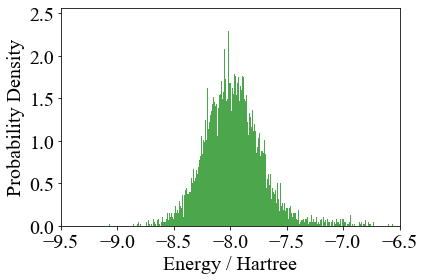

In [112]:
from matplotlib import pyplot
%matplotlib inline


# bins = len(set(E_list_SEQ_ROT_sim))
# bins_standard = len(set(E_list_STANDARD_sim))

# bins_standard = 5000
bins_standard = 150_000

bin_heights_STANDARD, bin_borders_STANDARD, _=pyplot.hist(E_list_STANDARD_sim,
                                                          bins_standard, alpha=0.7,
                                                          label='$E$ standard VQE - sim',
                                                          color='g',
                                                          density=True)



##############


pyplot.rcParams["font.family"] = "Times New Roman"
# pyplot.legend(loc='upper right')
# # pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-9.5,-5.5,0.5), fontsize=20)
pyplot.yticks(np.arange(0,3,0.5), fontsize=20)

# pyplot.xlim(np.floor(min(bin_borders_STANDARD)), np.ceil(max(bin_borders_STANDARD)))
pyplot.xlim(-9.5, -6.5)


pyplot.tight_layout()

# file_name = 'LiH_Histogram_STANDARD_sim_Gaussian.jpeg'
# pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

In [69]:
from scipy import stats

In [70]:
print(stats.shapiro(E_list_STANDARD_sim))
print(stats.kstest(E_list_STANDARD_sim, 'norm'))

/Users/lex/anaconda3/envs/UpdatedCirq/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9651805758476257, 0.0)
KstestResult(statistic=0.9999993680558639, pvalue=0.0)


# XY Z comparison

In [110]:
i_list_XY=[]
STANDARD_Hist_data_XY={}

i_list_Z=[]
STANDARD_Hist_data_Z={}
amplitude_min=0.00
XY_terms=[]
Z_amp_sum=0

for key in STANDARD_Hist_data_sim:
    Pword, const = STANDARD_Hist_data_sim[key]['P']
    coeff=STANDARD_Hist_data_sim[key]['coeff']
    
    if np.abs(coeff)>amplitude_min:
        qubitNos, qubitPstrs = zip(*(list(Pword)))
        # XY terms only!
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            i_list_XY.append(key)
            STANDARD_Hist_data_XY[key]=STANDARD_Hist_data_sim[key]
            XY_terms.append(STANDARD_Hist_data_sim[key]['P'])
        else:
            i_list_Z.append(key)
            STANDARD_Hist_data_Z[key]=STANDARD_Hist_data_sim[key]
            Z_amp_sum+=coeff
Z_amp_sum

5.237148798738557

In [73]:
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[list(Histogram_data.keys())[0]]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [74]:
I_term = -4.142299396835105

E_list_STANDARD_XY=Get_Hist_data(STANDARD_Hist_data_XY, 0)
E_list_STANDARD_Z=Get_Hist_data(STANDARD_Hist_data_Z, 0)

100%|██████████| 1616700/1616700 [03:34<00:00, 7529.63it/s]


In [134]:
print(len(set(np.around(E_list_STANDARD_XY, 5))))
print(len(set(np.around(E_list_STANDARD_Z, 5))))

106136
9536


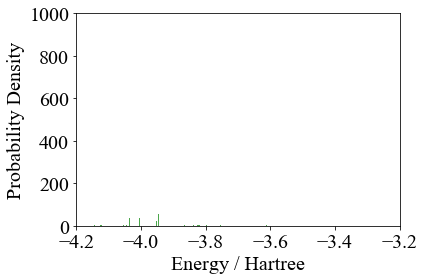

In [144]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
# bins_standard = 1000
bins_standard=8_000

# bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_STANDARD_XY,
#                                                           bins_standard, alpha=0.7,
#                                                           label='$XY$ terms',
#                                                           color='b',
#                                                           density=False)

bin_heights_Z, bin_borders_Z, _=pyplot.hist(E_list_STANDARD_Z,
                                                          bins_standard, alpha=0.7,
                                                          label='$Z$ terms',
                                                          color='g',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-4.2,-3.0,0.2), fontsize=20)
pyplot.xlim((-4.2, -3.2)) 
pyplot.yticks(np.arange(0,1200,200), fontsize=20)
pyplot.ylim((0, 1000)) 

pyplot.tight_layout()

file_name = 'LiH_standard_Z.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

In [145]:
np.where(bin_heights_Z==max(bin_heights_Z))[0]

array([2334])

In [161]:
print(bin_heights_Z[2334])
print('left sum:',sum(bin_heights_Z[:2334]))
print('right sum:', sum(bin_heights_Z[2335:]))
# therefore slighlt more likely to get more +ve energy!!!

951.3579852420173
left sum: 504.8055111080494
right sum: 518.2528410337952


In [ ]:
bin_borders_Z[583]

In [108]:
print(len(np.where(np.array(E_list_STANDARD_Z)>-3.8)[0]))
print(len(np.where(np.array(E_list_STANDARD_Z)<-3.89)[0]))
len(E_list_STANDARD_Z)

411283
372029


1616700

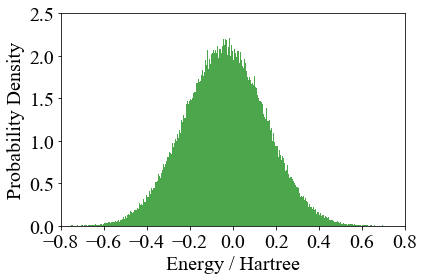

In [136]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
# bins_standard = 1000
bins_standard = 5000

bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_STANDARD_XY,
                                                          bins_standard, alpha=0.7,
                                                          label='$XY$ terms',
                                                          color='g',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-0.8,0.9,0.2), fontsize=20)
pyplot.xlim((-0.8, 0.8)) 
pyplot.yticks(np.arange(0,3,0.5), fontsize=20)


pyplot.tight_layout()

file_name = 'LiH_standard_XY.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()